<h1><center> Detecting Fraud in E-Commerce Website Purchases </center></h1>

<figure>
  <center><img src="fraud_toon.png" width = "700"/>
      <figcaption><b>Fig.1</b> - Anamolous. </figcaption></center>
</figure>

<b>Author:</b> Nitya Mandyam <br>
<b>Contact:</b> nityamd@gmail.com <br>
<b>Last Modified:</b> 07/08/2019


<h2> Dataset: </h2>

"Fraud_Data" - information about each user first transaction <br>

Notebook organization:
First impressions contains all the plots.

<h2> Columns: </h2>

1. user_id: Unique user ID
2. signup_time: The time when the user created their account (GMT time)
3. purchase_time: The time when the user bought the item (GMT time)
4. purchase_value: The cost of the item purchased (USD)
5. device_id: The device id. You can assume that it is unique by device. (If two transactions have the same device ID that means that the same physical device was used to purchase)
6. source: User marketing channel: ads, SEO, direct 
7. browser: The browser used by the user.
8. sex: User sex: Male/Female
9. age: user age
10. ip_address: user numeric IP address
11. class: This is the target variable. Fraudulent activities is tagged as ‘1’, whereas non-fraudulent activities are tagged as ‘0’



<h2> Table of Contents:<a name="TOC"></a></h2>

- [0. Problem Statement](#Objective)
- [1. Exploratory Data Analysis ](#EDA)
- [2. Feature Selection](#FS)
- [3. Feature Engineering](#FE)
- [4. Modeling Strategy](#Preprocessing)
- [5. Model 1](#model1)
- [6. Model 2](#model2)
- [7. Conclusions and Actionable Insights](#Conclusion)

<h2>0. Problem Statement <a name="Objective"></a></h2>


The dataset explored here is from an E-Commerce website and contains information about first time users' transactions in the year 2015. The goal is to build a model that would predict fradulent transactions.<br>

Fraud in E-Commerce is a prevalent problem and there are various kinds of frauds including and not limited to: Card Not Present (CNP), where stolen/fake credit cards are employed, Return to Origin (RTO) fraud, wbere the store's refund policy is abused or the creation of multiple user accounts with a view to abuse promo codes. While I may not currently have the necessary domain expertise in this area to delve too deeply into the mechanisms of E-Commerce Fraud, it is worth noting the above as we do indeed come across some of those instances listed above in this report. <br>

**Machine Learning** has been playing a useful and exciting role in detecting these fraudulent transactions where sophisticated algorithms are able to detect subtle patterns in the data that might escape the purview of manual analysis. Further, the amount of traffic in such platforms makes it critical to use fast, clear and interpretable techniques to parse and analyze these large amounts of data. <br>

The cannonical fraud/anomaly detection problem is an imbalanced data problem and our dataset here is no different. <br>

<h2>1. Exploratory Data Analysis <a name="EDA"></a></h2>

<h3> 1. First Impressions </h3>

In [5]:
#Notebook preferences
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import sklearn
import os


rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = False
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

In [6]:
df = pd.read_csv("../../fraud/Fraud_Data.csv")
print(len(df))
df.head()

151112


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


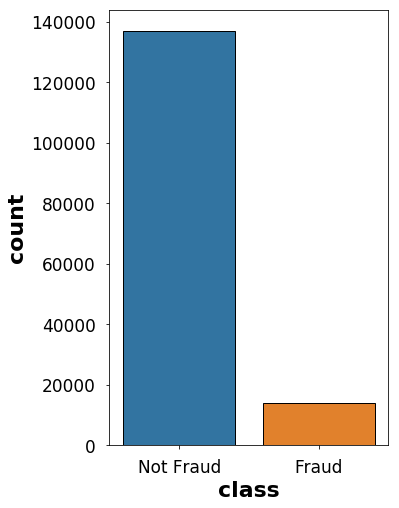

In [7]:
#lag-time, purchase-time, country_risk_score, multiple users per device; 
# Global variables for plotting.
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22, 'figure.figsize': (12,12)})
#pink_palette = ['#FC4993', '#70D6FF']


fig, ax = plt.subplots(figsize=(5,8))
sns.countplot(df['class'], ax=ax, edgecolor='black')
ax.set_xticklabels(['Not Fraud', 'Fraud'])
plt.savefig('class_imbalance.png')
plt.show();

In [4]:
df.nunique()

user_id           151112
signup_time       151112
purchase_time     150679
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143512
class                  2
dtype: int64

A few things to note here:


In [5]:
country = pd.read_csv("../../fraud/IpAddress_to_Country.csv")
print(len(country.country.unique()))
country.head()

235


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


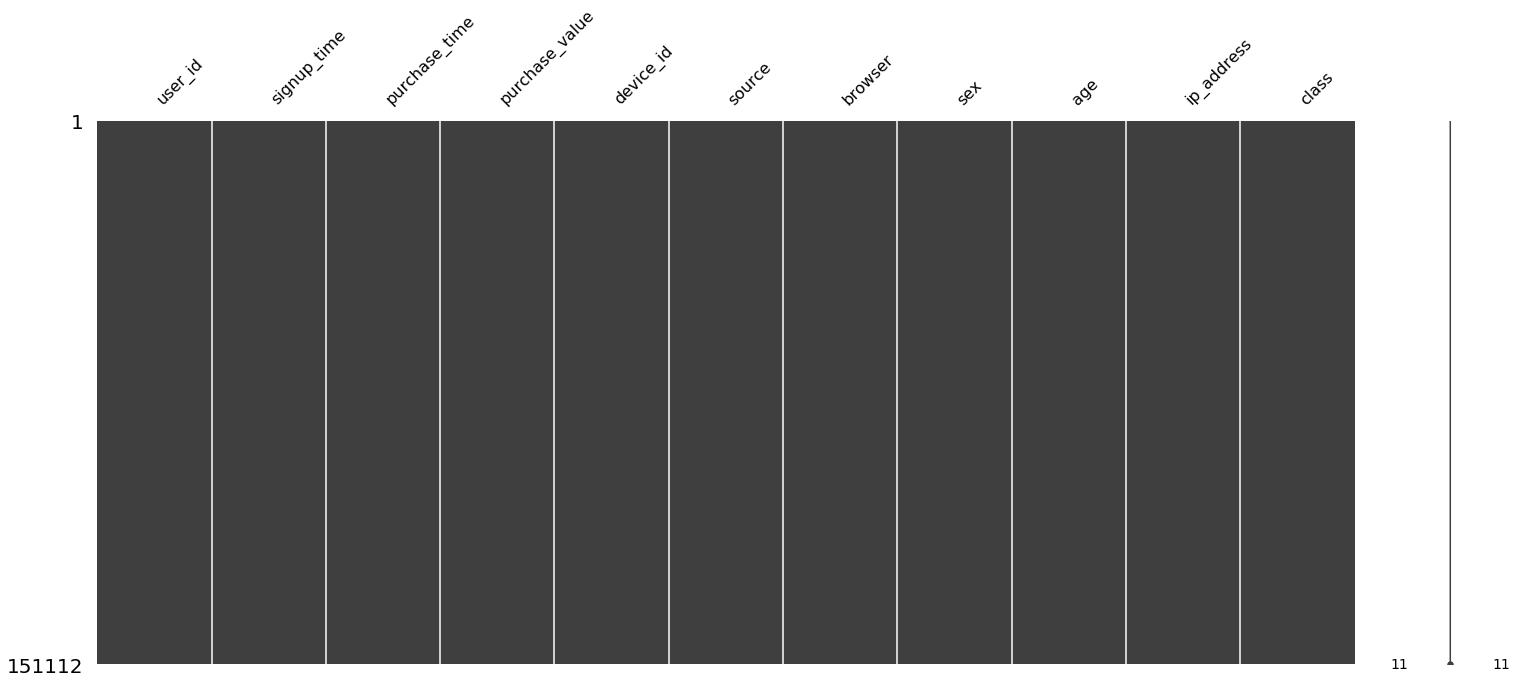

In [6]:
#Checking for Missing data
import missingno as msno
msno.matrix(df)

No missing data, yay!  (Check out [https://github.com/ResidentMario/missingno](https://github.com/ResidentMario/missingno) for details on this very useful package.)

In [7]:
# #Look at each column:
# corr = df.corr()
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# f, ax = plt.subplots(figsize=(11, 9))
# #mask = np.zeros_like(corr, dtype=np.bool)
# #mask[np.triu_indices_from(mask)] = True
# sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


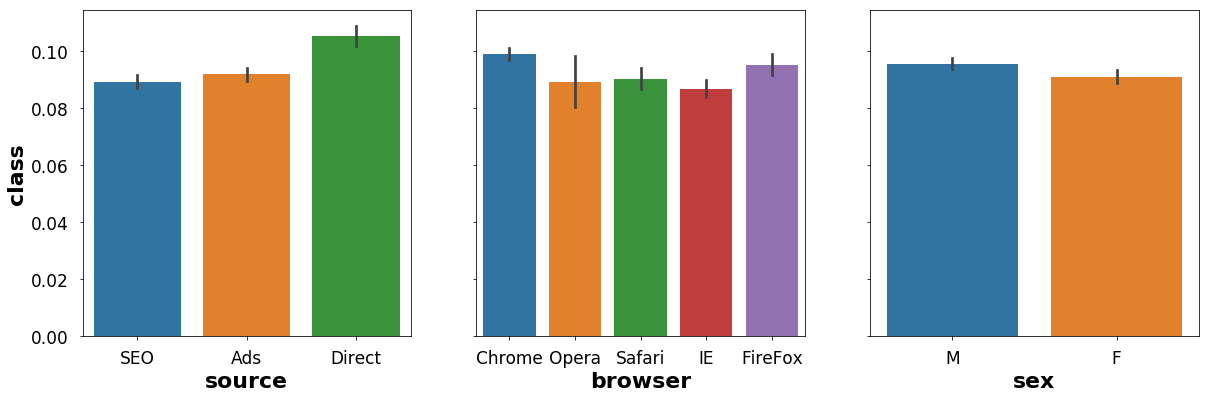

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,6), sharey = True)

sns.barplot(x = 'source', y = 'class', ax = ax1,  data = df);
sns.barplot(x = 'browser', y = 'class', ax = ax2, data = df);
sns.barplot(x = 'sex', y = 'class', ax = ax3, data = df);

ax2.set_ylabel('')    
ax3.set_ylabel('')
plt.show()

/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


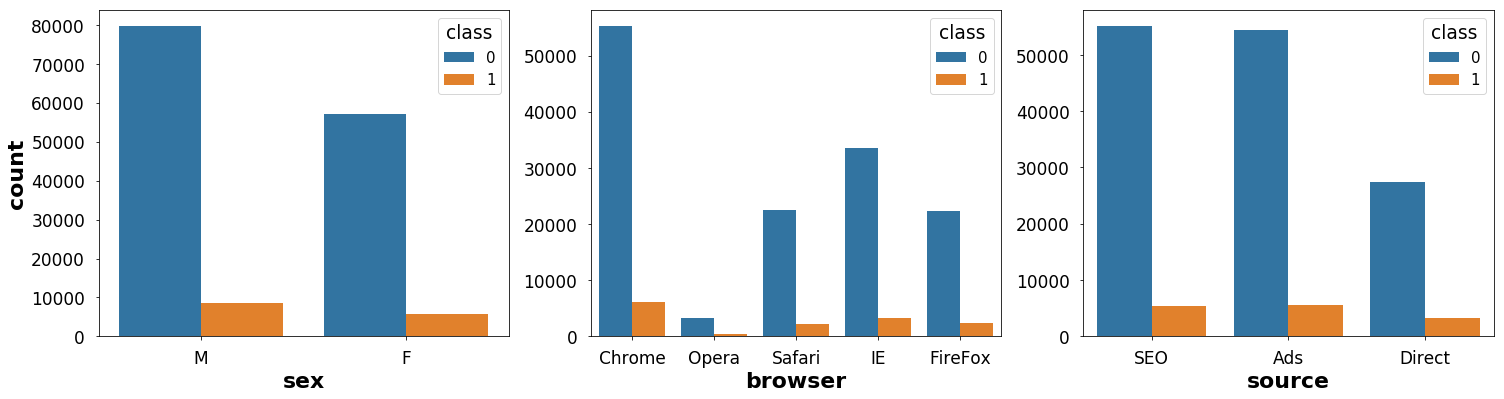

In [9]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (25,6))

sns.countplot(x = 'sex',hue = 'class', data = df, ax = ax1);
sns.countplot(x = 'browser',hue = 'class', data = df, ax =ax2);
sns.countplot(x = 'source',hue = 'class', data = df, ax = ax3);

ax2.set_ylabel('')    
ax3.set_ylabel('')
plt.show()

<h3> 1. Country Table Join </h3>

In [10]:
#Converting the IP Addresses to Floats
country.upper_bound_ip_address = country.upper_bound_ip_address.astype("float")
country.lower_bound_ip_address = country.lower_bound_ip_address.astype("float")
df.ip_address = df.ip_address.astype("float")

#Function to get country for IP Address
def get_country(ip):
    try :
        return country.country[(country.lower_bound_ip_address < ip)                            
                                & 
                                (country.upper_bound_ip_address > ip)].iloc[0]
    except IndexError:
        return "Unknown"

In [11]:
#Appending a country column
#df["country"] = df.ip_address.apply(get_country)
#df.to_csv("../../fraud/fraud_with_country.csv")

In [12]:
df = pd.read_csv("../../fraud/fraud_with_country.csv")
df.nunique()

Unnamed: 0        151112
user_id           151112
signup_time       151112
purchase_time     150679
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143512
class                  2
country              182
dtype: int64

In [13]:
#Looking at the fraud percentage by country (country_fraud: cf)
country_fraud = pd.DataFrame(df.groupby(by="country").mean()["class"].sort_values(ascending = False))

In [14]:
country_fraud.head()

,class
country,
Turkmenistan,1.000000
Namibia,0.434783
Sri Lanka,0.419355
Luxembourg,0.388889
Virgin Islands (U.S.),0.333333


In [15]:
# Risk as a categorical variable..?
#country_fraud["risk_cat"] = risk_country["class"].apply(lambda x : 
 #                                                          "Very High risk" if x > 0.25 else
  #                                                         "High risk" if x > 0.05 else
   #                                                        "Medium risk" if x > 0.01 else
    #                                                       "Low risk")

CAN BE MOVED TO FEATURE ENGINEERING HEURISTICS

In [16]:
#Country Fraud Distribution

In [17]:
#Assigning risk scores according to the fraud percentages
country_fraud["risk_score"] = country_fraud["class"].apply(lambda x : 
                                                           3 if x > 0.25 else
                                                           2 if x > 0.05 else
                                                           1 if x > 0.01 else
                                                           0)

In [18]:
df = df.merge(country_fraud.drop("class", axis = 1), left_on= "country", right_index = True).reset_index()

In [19]:
df.head()

,index,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,risk_score
0,0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,2
1,32,32,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,0,Japan,2
2,40,40,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,0,Japan,2
3,106,106,28074,2015-07-03 09:31:29,2015-08-07 20:12:17,22,GQOICTLWVUQJR,Ads,Chrome,M,36,7.289345e+08,0,Japan,2
4,108,108,135536,2015-05-03 22:40:07,2015-07-18 15:43:38,32,ITRXCOXKEQTAM,SEO,FireFox,M,37,2.097968e+09,0,Japan,2


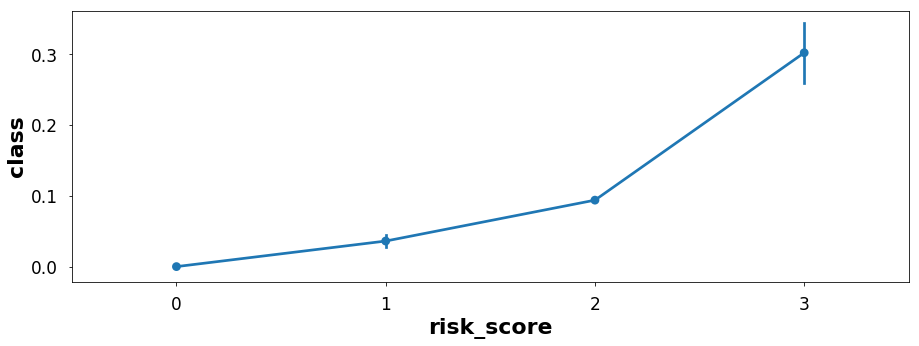

In [20]:
fig, ax = plt.subplots(1,1,figsize = (15,5))
sns.pointplot(x = 'risk_score', y = 'class', data = df, kind ="point",
            ax =ax, xlabel = 'Risk Score')
plt.show()

Countries to Continents possibly?

<h3> 2. A look at Signup/Purchase times </h3>

In [21]:
#convert everything to datetime objects

df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['signup_time'] = pd.to_datetime(df['signup_time'])

print(df['signup_time'].min(), df['signup_time'].max(), df['purchase_time'].min(), df['purchase_time'].max())

2015-01-01 00:00:42 2015-08-18 04:40:29 2015-01-01 00:00:44 2015-12-16 02:56:05


<h4> 1. Day of Signup/Purchase </h4>

In [22]:
#Calmap!!! To make pretty time series visualizations
import calmap

#Two time series data frames: one for purchase time and another for signup time.
ts_signup = df.set_index('signup_time')
ts_purchase = df.set_index('purchase_time')

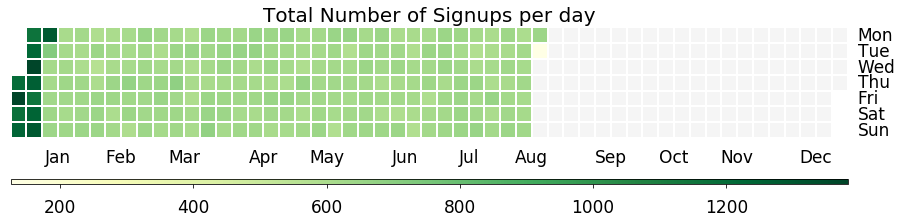

In [23]:
fig, ax = plt.subplots(figsize = (15,5))
cax = calmap.yearplot(ts_signup['class'],how=u'count', cmap='YlGn')
cbar = fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal', aspect=150)
plt.title('Total Number of Signups per day')
plt.show()

A lot of signups in the first two weeks of the year!

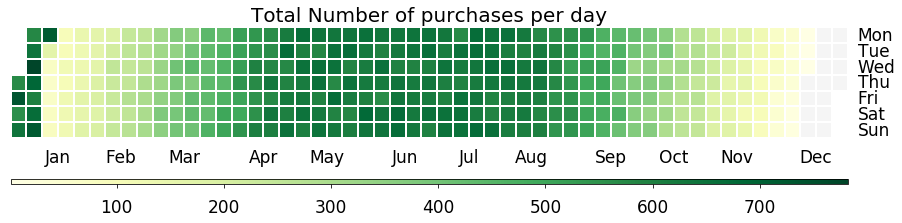

In [24]:
fig, ax = plt.subplots(figsize = (15,5))
cax = calmap.yearplot(ts_purchase['class'],how=u'count', cmap='YlGn')
cbar = fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal', aspect=150)
plt.title('Total Number of purchases per day')
plt.savefig('/Users/nitya/Desktop/purchases.pdf')
plt.show()

.... and a lot of *purchases* in the exact same weeks..?! The obvious next thing ask would be: what percentage of these purchases that were **frauds**?

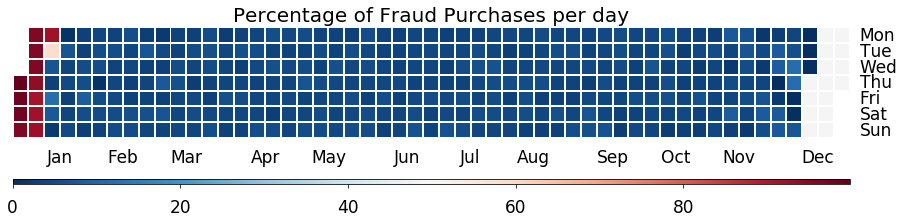

In [25]:
fig, ax = plt.subplots(figsize = (15,5))
#cmap_mine = matplotlib.colors.ListedColormap(['white', 'red'])
cax = calmap.yearplot(ts_purchase['class']*100,how=u'mean', cmap='RdBu_r')
cbar = fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal', aspect=150)
plt.title('Percentage of Fraud Purchases per day')
plt.savefig('/Users/nitya/Desktop/fraud_percentages.pdf')

Text(0.5, 1.0, 'Average values of the purchases per day')

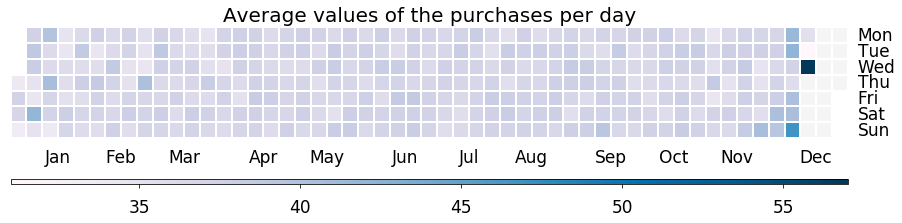

In [26]:
fig, ax = plt.subplots(figsize = (15,5))
#cmap_mine = matplotlib.colors.ListedColormap(['white', 'red'])
cax = calmap.yearplot(ts_purchase['purchase_value'],how=u'mean',
                      cmap = "PuBu")
cbar = fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal', aspect=150)
plt.title('Average values of the purchases per day')

Text(0.5, 1.0, 'Average age of Purchasers each day')

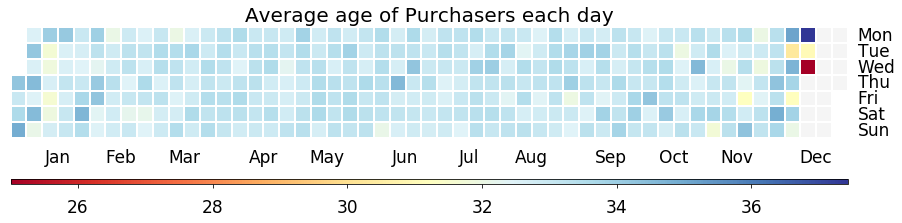

In [27]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (15,5))
cax = calmap.yearplot(ts_purchase['age'],how=u'mean',
                      cmap=ListedColormap(sns.color_palette("RdYlBu",1000)))
cbar = fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal', aspect=150)
plt.title('Average age of Purchasers each day')

<h4> 2. A look at lag times </h4>

In [28]:
#Calculating lag time, i.e, the lag between signup and purchase
df['lag_time'] = df['purchase_time'] - df['signup_time']

df['lagdays'] = df['lag_time'].dt.days

df['lagsecs'] = df['lag_time'].dt.total_seconds()
df['laghours'] = df['lagsecs']//3600
df['lagmilli'] = df['lag_time'].astype(np.int64)/int(1e6)

A few interesting things happened while looking at the class distributions across days, hours, minutes and then seconds as plotted below:

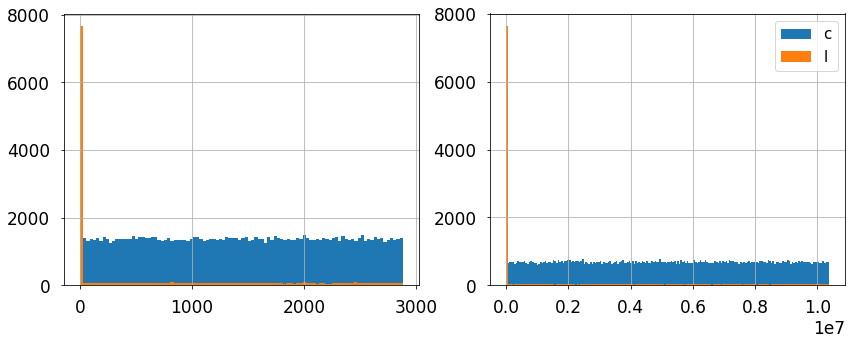

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (14,5))
df.groupby('class')['laghours'].hist(ax=ax1, bins = 100)
ax.legend('class', loc = 0);
df.groupby('class')['lagsecs'].hist(ax=ax2, bins = 200)
ax2.legend('class');

Weird, huh? So it appears as though there are many "flash purchases" that are categorized as fraud.
Let's see what the time interval for these actually are:

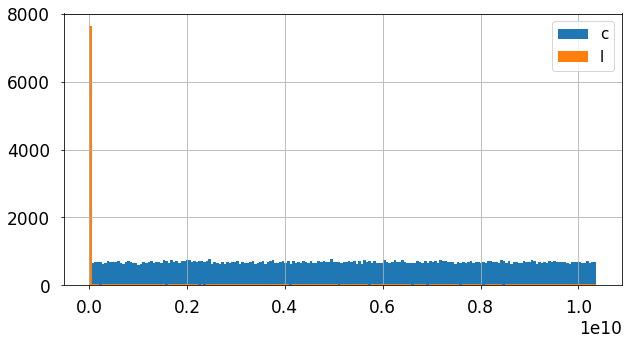

In [30]:
fig, ax = plt.subplots(figsize = (10,5))
df.groupby('class')['lagmilli'].hist(ax=ax, bins = 200)
ax.legend('class');

In [31]:
df.lag_time.min()

Timedelta('0 days 00:00:01')

The minimum lag time seems to be 1 second: i.e. 1000 milliseconds. This seems to be too short a time for a human being to make a transaction. 
Let's see if there are any non-frauds with this seemingly impossibly lag time.

In [32]:
df.query('lagmilli == 1000').groupby('class')['user_id'].count()

class
1    7600
Name: user_id, dtype: int64

None! Almost half the fraudulent transations are within a second! (Less than a second might be impossible due to resolution issues...)

No handles with labels found to put in legend.


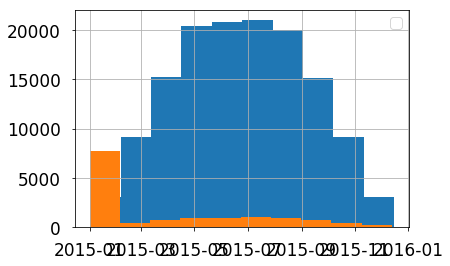

In [33]:
fig, ax = plt.subplots()
df.groupby('class')['purchase_time'].hist(ax=ax)
ax.legend();

<h4> 3. Time of Day of Purchases </h4>

No handles with labels found to put in legend.


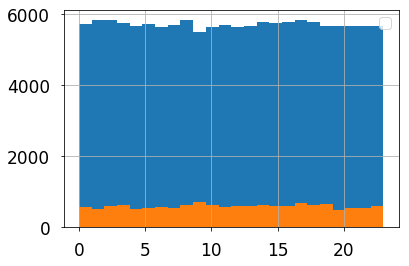

In [34]:
df['purchase_hour'] = df.signup_time.dt.hour

fig, ax = plt.subplots()
df.groupby('class')['purchase_hour'].hist(ax=ax, bins = 24)
ax.legend();

<h3>3. Investigating Device Frequency </h3>

In [35]:
num_duplicates = pd.DataFrame(df.duplicated(subset = "device_id")).mean()
print("{}% of the dataset is comprised of transactions from a device_id that had been previously used".format(int(num_duplicates*1000)/10))

8.7% of the dataset is comprised of transactions from a device_id that had been previously used


In [36]:
dup_df = pd.DataFrame(df.groupby(by = "device_id").device_id.count())  # at this moment, index column name and first column name both are equal to "device_id"
dup_df.rename(columns={"device_id": "freqdevice"}, inplace=True)           # hence we need to replace the "device_id" column name
dup_df.reset_index(level=0, inplace= True)                                  # and then we turn device_id from index to column

dupli = dup_df[dup_df.freqdevice >1]
print("On average, when a device is used more than once it is used {mean} times, and the most used machine was used {maxi} times"
      .format(mean = int(dupli.mean()*10)/10, maxi = int(dupli.freqdevice.max()*10)/10))

dupli = dup_df[dup_df.freqdevice >2]
print("On average, when a device is used more than twice it is used {mean} times"
      .format(mean = int(dupli.mean()*10)/10, maxi = int(dupli.freqdevice.max()*10)/10))

On average, when a device is used more than once it is used 3.1 times, and the most used machine was used 20.0 times
On average, when a device is used more than twice it is used 10.2 times


In [37]:
# finally we merge with dataset
df = df.merge(dup_df, on= "device_id")

No handles with labels found to put in legend.


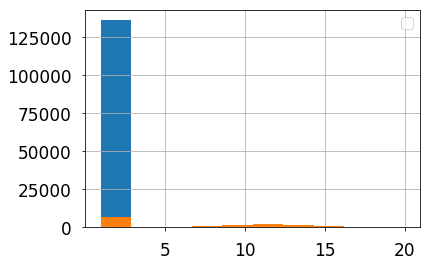

In [38]:
fig, ax = plt.subplots()
df.groupby('class')['freqdevice'].hist(ax=ax)
ax.legend();

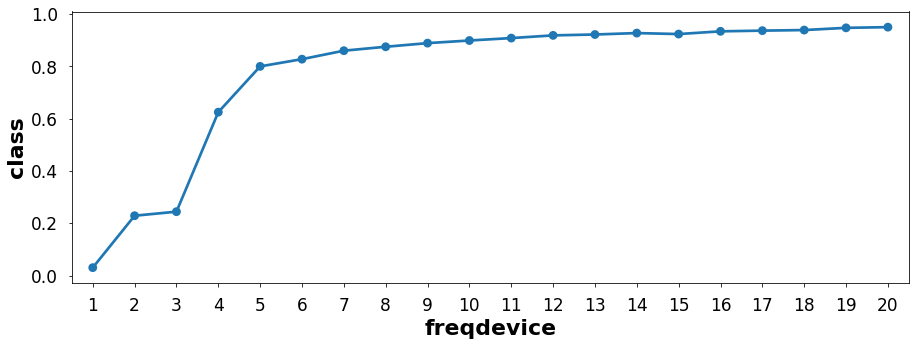

In [39]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(x = "freqdevice", y= "class", data = df, logistic=True, ci=None, ax =ax);

In [40]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

<h3> Data Preprocessing </h3>

In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [42]:
#One hot encode Browser, Source and Sex
sex = pd.get_dummies(df['sex'], prefix = 'sex')
df = pd.concat([df, sex.iloc[:, :2]], axis=1)

source = pd.get_dummies(df['source'], prefix = 'source')
df = pd.concat([df, source.iloc[:, :3]], axis=1)

browser = pd.get_dummies(df['browser'], prefix = 'browser')
df = pd.concat([df, browser.iloc[:, :3]], axis=1)

In [43]:
df.head()

,index,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,...,purchase_hour,freqdevice,sex_F,sex_M,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE
0,0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,...,22,1,0,1,0,0,1,1,0,0
1,32,32,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,...,18,1,1,0,0,1,0,1,0,0
2,40,40,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,...,12,1,1,0,0,1,0,1,0,0
3,106,106,28074,2015-07-03 09:31:29,2015-08-07 20:12:17,22,GQOICTLWVUQJR,Ads,Chrome,M,...,9,1,0,1,1,0,0,1,0,0
4,108,108,135536,2015-05-03 22:40:07,2015-07-18 15:43:38,32,ITRXCOXKEQTAM,SEO,FireFox,M,...,22,2,0,1,0,0,1,0,1,0


In [47]:
df.columns

Index(['index', 'Unnamed: 0', 'user_id', 'signup_time', 'purchase_time',
       'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age',
       'ip_address', 'class', 'country', 'risk_score', 'lag_time', 'lagdays',
       'lagsecs', 'laghours', 'lagmilli', 'purchase_hour', 'freqdevice',
       'sex_F', 'sex_M', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE'],
      dtype='object')

In [55]:
data = df.drop(columns = ['index', 'Unnamed: 0', 'user_id', 'signup_time', 'purchase_time',
               'source', 'browser', 'sex', 'country', 'lag_time', 'lagdays',
               'laghours', 'lagmilli', 'ip_address', 'device_id'])

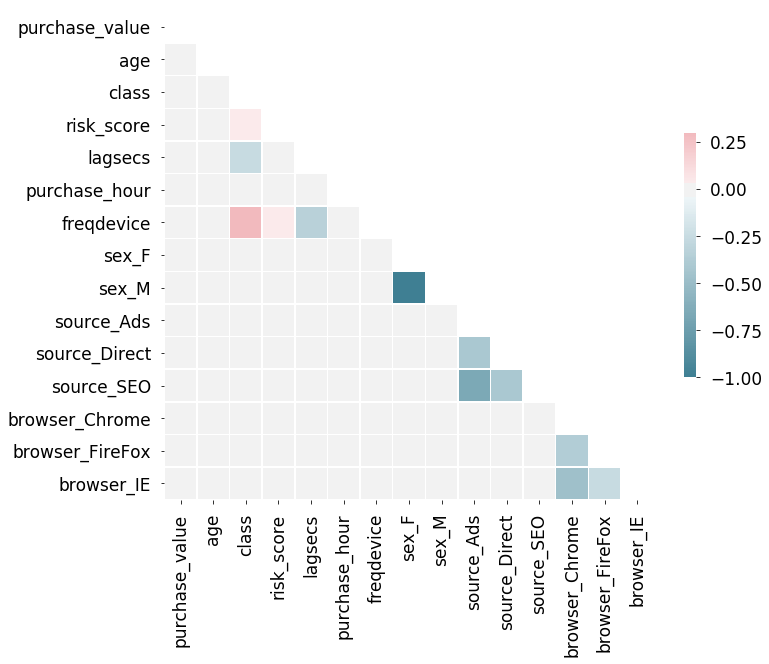

In [56]:
rcParams["text.usetex"] = False
#Look at each column:
corr = data.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,cmap = cmap, vmax=.3, center=0, mask = mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [57]:
data.to_csv('../../Fraud/features.csv')

In [ ]:
df[df['lagsecs']==1]['freqdevice'].hist()

In [ ]:
df[(df['lagsecs']==1) & (df['class']==0)]['freqdevice'].hist()

<h3> Insights thusfar: </h3>

1. Half the frauds are within  the first two weeks; Not only that, they are all 


MVP:<br>

Model with the following features:

1. Do a random 80:20 split;
2. Features: Lagtime, Device-freq, Country_risk_score (mark's suggestion: scale it 0-1),
3. 



1. Correlation matrix
2. Device frequency: mean fraud;
3. Logistic Regression, Decision Tree.
4. Imbalanced data: SMOTE
5. The 2 model thing: blatant fraud vs subtle fraud

6. We want to control for recall: We don't want to lose loyal customers (i.e. device frequency)


80:20 split before i do anything else: do it randomly

(or 80:10:10 test:train:validation)
Demographics of their customer: how are they changing?
(Customer focussed insights)
Kewl Viz.
Month by month country plot: 
Plotly.

Calendar heatmap from pandas. https://pythonhosted.org/calmap/


Validation: k-fold cross validation
Color palette - a la Melissa.